## readme

exp27: exp15ベース（）


In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pylab as plt
from sklearn import preprocessing
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")

In [2]:
exp = "exp27"
target = "MIS_Status"
cols_category = [
    "RevLineCr", "LowDoc", "Sector",
    "State", "BankState", "FranchiseCode",
    "City", "DisbursementDate", "ApprovalDate",
    "DisbursementGross", "GrAppv", "SBA_Appv",
]

params_cat = {
    "iterations": 3000,
    "learning_rate": 0.01,
    "subsample": 0.7207134190578636,
    "colsample_bylevel": 0.7201211165655252,
    "max_depth": 9,
    "random_seed": 0,
}

In [3]:
df_train = pd.read_csv("../input/sig-sba/train.csv", index_col=0)
df_test = pd.read_csv("../input/sig-sba/test.csv", index_col=0)
ss = pd.read_csv("../input/sig-sba/sample_submission.csv", header=None)

## 前処理

In [4]:
def preprocess(df, replace_dict=None, ce_dict=None):    
    # 本来数値型のものを変換する
    cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]
    df[cols] = df[cols].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float).astype(int)
    
    # 上2桁が意味あるらしいので
    df['FranchiseCode'] = [int(str(code)[:2]) if code > 100 else code for code in df['FranchiseCode']]

    # 特徴量エンジニアリング
    df["State_is_BankState"] = (df["State"] == df["BankState"])
    df["State_is_BankState"] = df["State_is_BankState"].replace({True: 1, False: 0})
    df['SBA_Gr_Ratio'] = df['SBA_Appv'] / df['GrAppv']
    df["DisbursementGross_Gr_Ratio"] = df["DisbursementGross"] / df["GrAppv"]
    df["DisbursementGross_SBA_Ratio"] = df["DisbursementGross"] / df["SBA_Appv"]
    
    # コード
    # 31-33, 44-45, 48-49 は同じらしい
    code_dict = {
        32: 31,
        33: 31,
        45: 44,
        49: 48
    }
    df["Sector"] = df["Sector"].replace(code_dict)

    # 日付関係
    df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'], format='%d-%b-%y')
    df["DisbursementYear"] = df["DisbursementDate"].dt.year
    df["ApprovalDate"] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y')
    df["ApprovalDateYear_is_ApprovalFY"] = (df["ApprovalDate"].dt.year == df["ApprovalFY"]).astype(int)
    df["FY_Diff"] = df["ApprovalFY"] - df["DisbursementYear"]
    
    # v11: cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]をカテゴリカル変数として追加（処理的にはcols_categoryに足した上でintに追加）
    cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]
    for col in cols:
        df[f"{col}_int"] = df[col].copy()
    
    # カテゴリカル変数の設定
    df[cols_category] = df[cols_category].fillna(-1)
    
    # train
    if replace_dict is None:
        # カウントエンコード＋数字にエンコード
        ce_dict = {}
        replace_dict = {}
        for col in cols_category:
            replace_dict[col] = {}
            vc = df[col].value_counts()
            ce_dict[col] = vc
            replace_dict_in_dict = {}
            for i, k in enumerate(vc.keys()):
                replace_dict_in_dict[k] = i
            replace_dict[col] = replace_dict_in_dict
            df[f"{col}_CountEncode"] = df[col].replace(vc).astype(int)
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df, replace_dict, ce_dict

    # test
    else:
        for col in cols_category:
            # カウントエンコード
            test_vals_uniq = df[col].unique()
            ce_dict_in_dict = ce_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in ce_dict_in_dict.keys():
                    ce_dict_in_dict[test_val] = -1
            df[f"{col}_CountEncode"] = df[col].replace(ce_dict_in_dict).astype(int)
            
            # 数字にエンコード
            test_vals_uniq = df[col].unique()
            replace_dict_in_dict = replace_dict[col]
            for test_val in test_vals_uniq:
                if test_val not in replace_dict_in_dict.keys():
                    replace_dict_in_dict[test_val] = -1
            df[col] = df[col].replace(replace_dict_in_dict).astype(int)
        return df

In [5]:
df_train, replace_dict, ce_dict = preprocess(df_train)
df_test = preprocess(df_test, replace_dict=replace_dict, ce_dict=ce_dict)

In [6]:
s_per = df_train.corr("pearson")[target].sort_values()
s_spr = df_train.corr("spearman")[target].sort_values()
df_corr = pd.concat([s_per, s_spr], axis=1)
df_corr = df_corr.loc[df_corr.mean(axis=1).sort_values(ascending=False).keys(), :].drop("MIS_Status")
df_corr

,MIS_Status,MIS_Status
RevLineCr_CountEncode,0.142624,0.134530
NoEmp,0.092940,0.171855
Term,0.122125,0.119292
LowDoc_CountEncode,0.112232,0.116404
Sector_CountEncode,0.104510,0.105012
City,0.073867,0.042356
DisbursementGross,0.072582,0.020391
GrAppv_CountEncode,0.056272,0.035001
DisbursementGross_SBA_Ratio,0.051381,0.034710
SBA_Appv_CountEncode,0.052683,0.033403


In [7]:
train_y = df_train[target]
train_x = df_train.drop(target, axis=1)

## 学習

In [8]:
from sklearn import metrics
def decide_cutoff(val_y, preds_y_proba):
    mean_f1_list = []
    fpr, tpr, thresholds = metrics.roc_curve(val_y, preds_y_proba)
    for threshold in thresholds:
        preds_y = [1 if prob > threshold else 0 for prob in preds_y_proba]
        mean_f1_list.append(f1_score(val_y, preds_y, average='macro'))
    plt.plot(thresholds, mean_f1_list)
    plt.show()
    return np.max(mean_f1_list), thresholds[np.argmax(mean_f1_list)]

0:	learn: 0.6835893	test: 0.6835186	best: 0.6835186 (0)	total: 180ms	remaining: 9m 1s
1000:	learn: 0.2336082	test: 0.2678367	best: 0.2678193 (963)	total: 2m 35s	remaining: 5m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2676523814
bestIteration = 1349

Shrink model to first 1350 iterations.


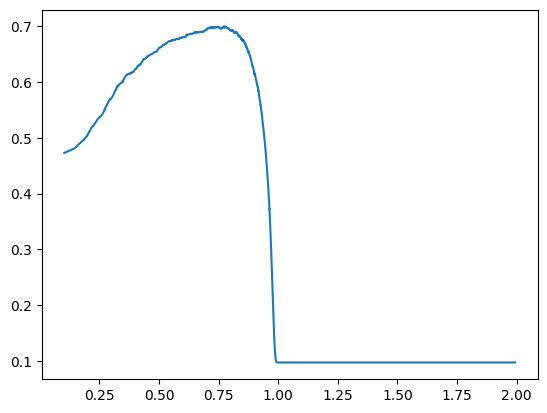

Fold: 1, Cat, AUC: 0.8016739096712189, F1: 0.699732216017454, Threshold: 0.7797809636808647
0:	learn: 0.6835794	test: 0.6835215	best: 0.6835215 (0)	total: 109ms	remaining: 5m 27s
1000:	learn: 0.2345236	test: 0.2686749	best: 0.2686445 (984)	total: 2m 38s	remaining: 5m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2684946872
bestIteration = 1153

Shrink model to first 1154 iterations.


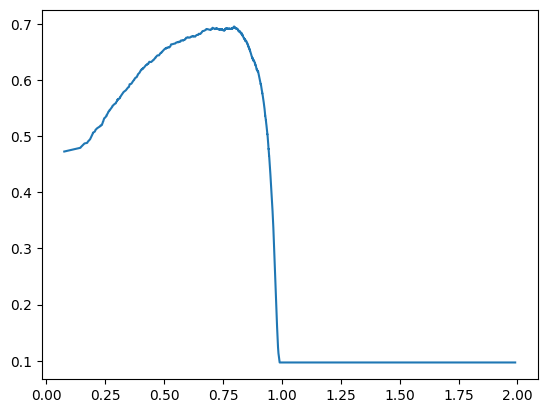

Fold: 2, Cat, AUC: 0.8024499667008406, F1: 0.6955913291871813, Threshold: 0.7970367818829533
0:	learn: 0.6833617	test: 0.6834620	best: 0.6834620 (0)	total: 134ms	remaining: 6m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2821565427
bestIteration = 577

Shrink model to first 578 iterations.


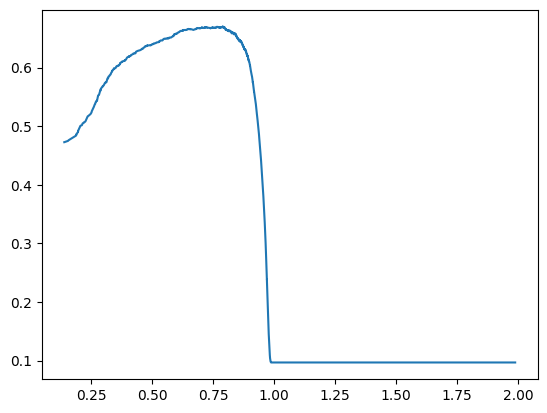

Fold: 3, Cat, AUC: 0.7775785331382169, F1: 0.6701996564222644, Threshold: 0.7904972452713327
0:	learn: 0.6829239	test: 0.6830409	best: 0.6830409 (0)	total: 132ms	remaining: 6m 36s
1000:	learn: 0.2332543	test: 0.2744340	best: 0.2744273 (997)	total: 2m 37s	remaining: 5m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2741115009
bestIteration = 1304

Shrink model to first 1305 iterations.


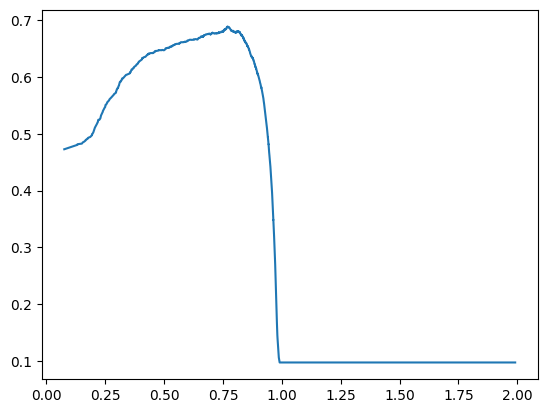

Fold: 4, Cat, AUC: 0.7951576845213064, F1: 0.6892230759777952, Threshold: 0.7696624522308825
0:	learn: 0.6837681	test: 0.6837436	best: 0.6837436 (0)	total: 60ms	remaining: 2m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2752861265
bestIteration = 699

Shrink model to first 700 iterations.


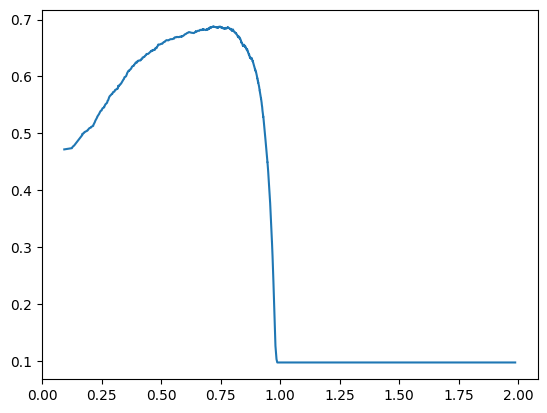

Fold: 5, Cat, AUC: 0.7879357386947218, F1: 0.6877587299574305, Threshold: 0.717674181353751


In [9]:
list_f1s = []
list_metrics = []
list_thresholds = []
list_models = []

cat_features_loc = [train_x.columns.get_loc(col) for col in cols_category]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_oof = df_train[["MIS_Status"]].copy()
df_oof["fold"] = np.nan
df_oof["pred"] = np.nan
for fold, (trn_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=1):
    trn_x = train_x.iloc[trn_idx, :]
    trn_y = train_y[trn_idx]
    val_x = train_x.iloc[val_idx, :]
    val_y = train_y[val_idx]
    
    model_cat = CatBoostClassifier(**params_cat)
    model_cat.fit(
        trn_x, trn_y,
        eval_set=(val_x, val_y),
        early_stopping_rounds=100,
        use_best_model=True,
        cat_features=cat_features_loc,
        verbose=1000,
    )
    list_models.append(model_cat)
    preds_y_proba = model_cat.predict_proba(val_x)[:, 1]
    auc = roc_auc_score(val_y, preds_y_proba)
    f1, threshold = decide_cutoff(val_y, preds_y_proba)
    print(f"Fold: {fold}, Cat, AUC: {auc}, F1: {f1}, Threshold: {threshold}")
    list_f1s.append(f1)
    list_thresholds.append(threshold)
    list_metrics.append(auc)
    df_oof.iloc[val_idx, 1] = fold
    df_oof.iloc[val_idx, 2] = preds_y_proba

## 精度評価

In [12]:
print(np.mean(list_metrics), np.mean(list_f1s), np.mean(list_thresholds))

0.7929591665452609 0.6885010015124251 0.7709303248839567


## 予測

In [13]:
ss_probs = ss.copy()
ss_probs.columns = ["ID", "score"]

cols_score = []
for fold, model in enumerate(list_models, start=1):
    ss_probs[f"score_fold{fold}"] = model.predict_proba(df_test[model.feature_names_])[:, 1]
    cols_score.append(f"score_fold{fold}")
ss_probs["score"] = ss_probs[cols_score].mean(axis=1)
ss_probs.to_csv(f"sample.nishimoto.{exp}.csv", index=False)

# 平均値
preds_y = [1 if prob > np.mean(list_thresholds) else 0 for prob in ss_probs["score"]]
ss[1] = preds_y
ss[1] = ss[1].astype(int)
ss.to_csv(f"submission.nishimoto.{exp}.csv", header=False, index=False)